## Imports and Common Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import t, norm, beta, multivariate_normal
from scipy.spatial import distance
from sklearn import datasets
import copy
import matplotlib.colors as mcolors

def euclidDist(x1,x2):
    return np.sqrt(np.sum((x1-x2)**2))

colors = ['k','r','b','g','c','m','y']
colors.extend(set(mcolors.CSS4_COLORS))

# Gaussian Mixture Model Optimization with Expectation Maximization

The GMM model works by assuming the data was genrated by a set of $K$ mixed Gaussians. With this assumption, we can make the claim that the model with the highest likelihood of generating the observed data is the best model. This implies that we are looking for the quantity $p(X)$ where $X$ is the set of observed data points. Each value in $X$ contains $D$ points such that each point in that vector is the observed position in the x, y, z dimension. Meaning $X$ is a $D$ by $N$ matrix storing each observed position of each data point. With $p(X)$, all that we need to do is maximize it. In order to find $p(X)$ we need to consider how the data is genrated within our model. We can represent a particular point as beloing to a particular a cluster by giving it a one hot encoded vector. This variable is called $z$. One hot encoded vectors are simply an array of 0s with a single 1 in the $k$th position that corresponds to that data point belonging to cluster $k$. The sum of every value in $z$ is 1, $\sum_{k=1}^K z_k = 1$. This is becuase each point can only belong to one particular cluster. If you wanted to generate $K$ clusters of $N$ data points, you would need to assign each data point a one hot encoded vector $z$. This implies some sort of generation of these "ownership" vectors. If we give each cluster a probability $\pi_k$ such that the probability a point belongs to the $k$th cluster is just $\pi_k$ then we can write the probability $p(z)$ as follows:

![GMMPZ](img/GMM_PZ.png)

Every position $k$ in the z vector that has a zero makes the exponential 0 therefore making the probability $\pi_k$ just get exponentiated into 1. Whereas the point when $z_k = 1$ will just return the $\pi_k$ variable as expected. With this sampling scheme we can generate a set of cluster ownerships. We can then make the assumption that each cluster has an associated Gaussian distribution. Taking advantage of the one hot encodedness of the $z$ vector we can write the conditional probability of a point as:

![GMM_PX](img/GMM_PX.png)

Then by the rules of conditional probability, we can sum over every configuration of $z$ and combine their probabilities with the conditonal probability of of $x$ to get the total probability of $x$. 

![GMMLH](img/GMM_LH.png)

This form of a likelihood implies a sampling struture. Each data point $n$ first samples the random variable $z$ which then feeds into the gaussians which are sampled to give $x_n$

![GMMBAYES](img/GMM_Bayes_Graph.png)

With the likelihood sorted, simply we just maximize the probability of observing the data. Note the fact that maximizing the regular likelihood is equivilent to maximizing the log of it. Giving the log probability as:

![GMMLH](img/GMM_LLH.png)

Taking the derivative of this function with respect to the means $\mu_k$ and then setting it to zero gives:

![MEAN.png](img/GMM_mean.png)

Define the responsibility $\gamma(z_{nk})$ as the fraction and $N_k$ as the sum of these responsibilites over each data point as follows: 

![GMMGAMMA](img/GMM_Responsibilites.png)

![GMMN](img/GMM_number.png)

Each of these terms can be interpereted with respect to the orginal problem. The responsibility is like the $\pi$ values defined above. It is the probability a new point gets assigned to cluster $k$ after you consider the data. In Bayesian terms, it is the posterior version of $\pi$. N is the effective number of points assigned to a particular cluster $k$. Solving this equation for $\mu_k$ gives: (In this solving I removed the variance in the previous equation by multiplying by $\Sigma_k^{-1}$ on either side) 

![GMMMEAN](img/GMM_Mean.png)

The variance can be solved similarly.

![GMMVar](img/GMM_Var.png)

For the $\pi$ parameters we have to include a lagrange multiplier in order to ensure that the values sum to 1 to make a valid probability. Making the cost function for $\pi$:

![GMMPi](img/GMM_Pi.png)

Then differentiating gives:

![GMMPi1](img/GMM_Pi1.png)

Because we know that the sum of $\pi_k$ is 1 we can use it to eliminate $\lambda$. Giving the relation:

![GMMPi2](img/GMM_Pi2.png)

This may seem great, however note the fact that every term complexly depends on the responsibility $\gamma_k$. This means this is not a closed set of equations. This can be resolved iteratively. If we choose an initial guess for each $\pi_k,\mu_k,\Sigma_k$ we can then evaluate the current responsibilites of each cluster. Essentially finding what we expect each of the points cluster ownership. Using this responsibilities we can then maximize the log likelihood within the derivative functions. By performing the expectation and then the maximization over and over then only stopping when the paramters converge/the log likelihood value converge will we have found a solution. Expectation maximization is a general algorithm that can be applied to more than just clustering problems. However the solution to a GMM is quite clean. Now to code it :).

In [2]:
def γ_set(X,μ_arr,Σ_arr,π_arr):
    
    K = len(μ_arr)
    
    # Create an array to store each \pi_k*N(X|\mu_k,\Sigma_k) such that it is indexed by the cluster index k
    mvnArray = np.zeros((K,len(X[0]))) 
    
    for k in range(K):
        mvn = multivariate_normal(μ_arr[k],Σ_arr[k])
        mvnArray[k] = mvn.pdf(X)*π_arr[k]
    
    # Compute the sum of each and then use that to normalize them
    Z = np.sum(mvnArray,0)
    for k in range(K):
        mvnArray[k] /= Z
    
    return mvnArray 

def LogLH(X,μ_arr,Σ_arr,π_arr):
    LH = 0
    for i in range(len(π_arr)):
        mvnSub = multivariate_normal(μ_arr[i],Σ_arr[i])
        LH += mvnSub.pdf(X)*π_arr[i]
        
    return np.sum(np.log(LH))

# Compute the results of GMM algorithm
# X = a 1 by N by D array such that N is the number of samples and D corresponds to the dimensonality of the data
# μ_init = The initial mean locations, K by D. Where K is the number of clusters
# Σ_init = Initial Variance Matrix, K by D by D. 
# π_init = Initial probability vector of belonging to cluster k. It must sum to 1. K by 1. 
# returnPath = True if you want to see the path π,μ, and Σ takes along their optimization
def GMM(X, μ_init, Σ_init, π_init,returnPath= False):
    
    K = len(μ_init)
    
    #Initialize fields and orgnize data. 
    μ = μ_init
    Σ = Σ_init
    π = π_init
    
    # Grade the convergence based on the change in the log LH. 
    # Once the chage in the LLH changes by less than this value the algorithm will stop.
    tolerance = 1e-20
    
    ΔLLH = 9999999 # Init delta to be super large
    LLH = 0
    
    MAX_ITERATIONS = 100
    iteration_count = 0
    
    # Store evaluated parameters on our journey to the minimum
    π_path = np.empty((MAX_ITERATIONS+1,K))
    μ_path = np.empty((MAX_ITERATIONS+1,K,2))
    Σ_path = np.empty((MAX_ITERATIONS+1,K,2,2))
    
    μ_path[0] = μ_init
    Σ_path[0] = Σ_init
    π_path[0] = π_init
    
    # Run until convergence of LLH or until we hit the max iterations.
    while iteration_count < MAX_ITERATIONS and ΔLLH > tolerance: 
        
        # EXPECTATION STEP
        
        # Compute the current responsibility for each class 
        Γ = γ_set(X,μ,Σ,π)  # (K,N) for ol faith (2,272)    
        N = np.sum(Γ,1) # (K) for ol faith (2,) 
       
        # MAXIMIZATION STEP
        
        μ_new = (Γ @ X[0]) # \sum_N \gamma_kn*\X_n (D,K) for ol faith (2,2) 
        for k in range(len(N)):
            μ_new[k] /= N[k]
        Σ_new = np.zeros((len(Σ),len(μ[0]),len(μ[0])))
        
        for k in range(len(Σ)):
            diff = (X[0] - μ[k])
            for d in range(len(X[0][0])):
                diff[:,d] *= Γ[k]
            Σ_new[k] = (1/N[k])*((X[0] - μ[k]).T @ diff)
                
        π_new = N/len(X[0])
        
        LLH_new =  LogLH(X,μ,Σ,π)
        
        # Calculate Tolerance
        ΔLLH = abs(LLH_new - LLH)
        
        LLH = LLH_new
        iteration_count += 1
        
        # Save Maximized Values
        μ = μ_new
        Σ = Σ_new
        π = π_new       

        μ_path[iteration_count] = μ
        Σ_path[iteration_count] = Σ
        π_path[iteration_count] = π
    
    # Creating a place to store the classification of the datum
    classification = []
    
    # In order to aid in plotting, ignore the soft classification and just assign the highest probability
    # In general this is not right but what can you do
    for point in X[0]:
        maxP = 0
        index = 0
        
        for k in range(len(π)):
            mvn = multivariate_normal(μ[k],Σ[k])
            p_k = mvn.pdf(np.array(point))
            if p_k > maxP:
                maxP = mvn.pdf(np.array(point))
                index = k
        classification.append(index)
        
    if returnPath:
        print("Steps to convergence:", iteration_count)
        return classification, μ_path, Σ_path, π_path
    return classification

## TEST GMM

In [3]:
from matplotlib.pyplot import figure

X_1 = np.random.multivariate_normal(np.array([-5,-5]),datasets.make_spd_matrix(2),100)
X_2 = np.random.multivariate_normal(np.array([5,5]),datasets.make_spd_matrix(2)/2,100)
X_3 = np.random.multivariate_normal(np.array([0,2]),datasets.make_spd_matrix(2)/3,100)

X = np.array([np.concatenate((X_1,X_2,X_3))])

μ_init = np.array([[0,0] for i in range(3)])
μ_init[0] = np.array([3,-6])
μ_init[1] = np.array([0,0])
μ_init[2] = np.array([5,4])

Σ_init= np.array([np.identity(2)*0.1 for i in range(3)])
π_init = np.array([0.5,0.25,0.25])

classification, μ_path, Σ_path, π_path = GMM(X, μ_init, Σ_init, π_init,True)

Steps to convergence: 13


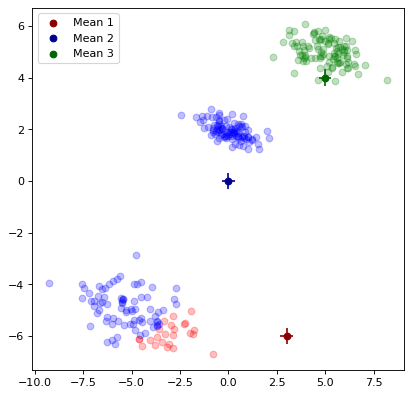

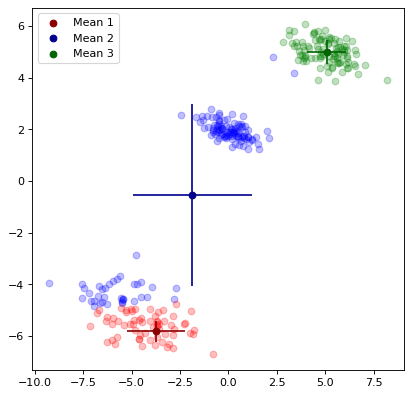

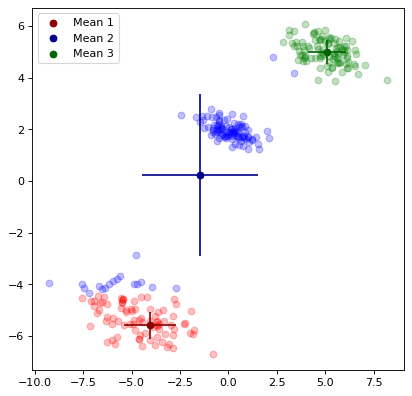

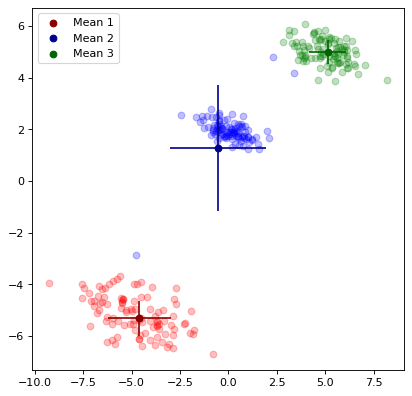

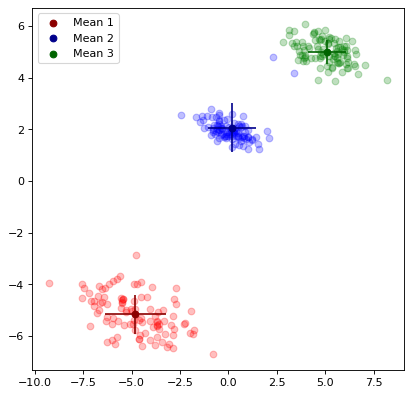

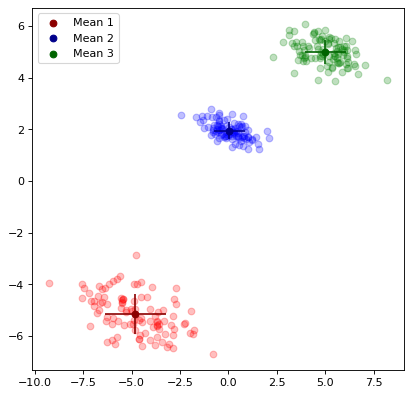

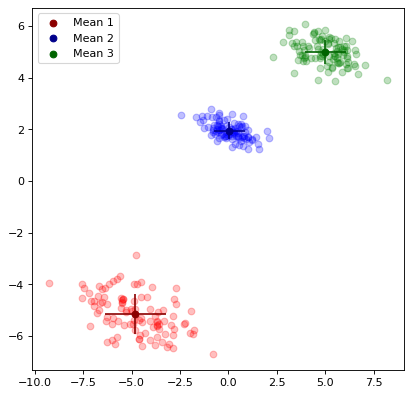

In [9]:
for step in range(0,13,2):
    
    figure(figsize=(6, 6), dpi=80)
    
    # Plot Datum
    # Abuse the soft classification. 
    for point in X[0]:
        
        maxP = 0
        index = 0
        
        for k in range(len(π_init)):
            mvn = multivariate_normal(μ_path[step][k],Σ_path[step][k])
            p_k = mvn.pdf(np.array(point))
            if p_k > maxP:
                maxP = mvn.pdf(np.array(point))
                index = k
        
        plt.scatter(point[0],point[1],color=colors[index + 1],alpha=0.25)
        
    # Plot Means:
    plt.scatter(μ_path[step][0][0],μ_path[step][0][1],color='darkred',label="Mean 1",marker="o")
    plt.scatter(μ_path[step][1][0],μ_path[step][1][1],color='darkblue',label="Mean 2",marker="o")
    plt.scatter(μ_path[step][2][0],μ_path[step][2][1],color='darkgreen',label="Mean 3",marker="o")
    
    # Plot Means:
    xstd = np.sqrt(Σ_path[step][0][0][0])
    ystd = np.sqrt(Σ_path[step][0][1][1])
    plt.vlines(μ_path[step][0][0],μ_path[step][0][1] - ystd,μ_path[step][0][1] + ystd,color='darkred')
    plt.hlines(μ_path[step][0][1],μ_path[step][0][0] - xstd,μ_path[step][0][0] + xstd,color='darkred')
    
    xstd = np.sqrt(Σ_path[step][1][0][0])
    ystd = np.sqrt(Σ_path[step][1][1][1])
    plt.vlines(μ_path[step][1][0],μ_path[step][1][1] - ystd,μ_path[step][1][1] + ystd,color='darkblue')
    plt.hlines(μ_path[step][1][1],μ_path[step][1][0] - xstd,μ_path[step][1][0] + xstd,color='darkblue')
    
    xstd = np.sqrt(Σ_path[step][2][0][0])
    ystd = np.sqrt(Σ_path[step][2][1][1])
    plt.vlines(μ_path[step][2][0],μ_path[step][2][1] - ystd,μ_path[step][2][1] + ystd,color='darkgreen')
    plt.hlines(μ_path[step][2][1],μ_path[step][2][0] - xstd,μ_path[step][2][0] + xstd,color='darkgreen')

    plt.legend()
    plt.show()

# K Means

K means clusterings goal can be summaraized in the definition of the distortion measure $J$:

![bruvvvv](img/KMEAN_Distortion.png)

The value $r_{nk}$ is a binary quantity. It is 1 if the point is n assigned to cluster k and 0 otherwise. It is just the sum of the squared distances from a point to its cluster mean $\mu_k$. The goal of the algorithm is to then minimize J with respect to the sets {$r_{nk}$} and {$\mu_k$}. The same ideas of expectation then maximization from GMM can be used here. First choose a vector $\mu_k$ and then minimize $J$ with respect to $r_{nk}$. Clearly the terms involving different n values are independent. This implies the minimization of $r_{nk}$ can be summarized in this expression.

![bruvvvv](img/KMEAN_Rmin.png)

Similarly, by fixing the r values you can minimize the means by differentiation. Setting the deriviative to zero gives:

![bruvvvv](img/KMEAN_Deriv.png)

Solving for mu gives:

![bruvvvv](img/KMEAN_MuMIn.png)

By first minimizing w.r.t. r then w.r.t. mu you can iteratively find the best set of means.

## Relation to Gaussian Mixture Models

K means is simply a limiting case of the Gaussain mixture model. Consider the probability of the data given a particular cluster mean and variance

![GMM_PX](img/GMM_PX.png)

By choosing the variance for every cluster as a fixed parameter ${\Sigma}_k$ as the identity ${I}$ times $\epsilon$ you recover this form for the probability. 

![KMEAN_SUBLH](img/KMEAN_LHSUB.PNG)

Remebering the responsibilities is defined as:

![GMMGAMMA](img/GMM_Responsibilites.png)

Applying this formula to the current likelihood will then give:

![KMEANGAMMA](img/KMEAN_Responsibilities.png)

Now imagine taking the limit where $\epsilon$ tends towards zero. Considering just one exponential in the summation in the denominator. The argument of the exponential will tend towards negative infinity meaning the exponential will tend to zero. The term where $||x_n-\mu_n||^2$ is the smallest will tend to zero the slowest. Therefore when taking the limit of the whole expression if the k is on the cluster with the smallest $||x_n-\mu_n||^2$ then the responsibilities tend to 1. Whereas if the k is not on that cluster it will tend to 0. This means that the responsibilies tends towards the $r_{nk}$ used within k means clustering. Taking this and then evaluating the total log likelihood of the latent classification $z$ as well as the likelihood of the data results in this quantitiy

![bruh](img/KMEAN_TotalLLH.png)

By maximizing the expected log likelihood is the same as minimizing the distortion measure used in K means. GMM is just a generic K means algorithm.

In [11]:
def KMEANS(X,μ_init,returnPath = False):
    
    # Initialize Datas
    
    N = len(X[0])
    K = len(μ_init)
    
    μ = μ_init # means, k,1
    r = np.empty((N,K))

    # Grade the convergence based on the change in the μ. 
    # Once the chage in μ changes by less than this value the algorithm will stop.
    tolerance = 1e-20
    
    Δμ = 9999999 # Init delta to be super large
    
    MAX_ITERATIONS = 100
    r_path = np.empty((MAX_ITERATIONS+1,N,K))
    μ_path = np.empty((MAX_ITERATIONS+1,K,2))
    
    iteration_count = 0
    while iteration_count < MAX_ITERATIONS and Δμ > tolerance:
        
        μ_path[iteration_count] = μ
        
        # EXPECTATION STEP
        
        # Compute best set of indicator variables given means
        for n in range(N):
            minIndex = 0
            minDist = 10000000000000000000 # big numba haha
            for k in range(K):
                squaredErr = (euclidDist(X[0][n],μ[k]))**2
                if (squaredErr < minDist):
                    minDist = squaredErr 
                    minIndex = k
                    
            r[n] = np.zeros(K)
            r[n][minIndex] = 1
                
        r_path[iteration_count] = r
    
        # MAXIMIZATION STEP
        
        # Compute best set of means given indicator variables
        R = np.sum(r,axis=0)
        rT = np.transpose(r)
        
        oldμ = μ
        
        μ = (rT @ X[0])
        
        for k in range(K):
            μ[k]/= R[k]
        
        Δμ = np.sum((μ-oldμ)**2)
        iteration_count += 1
        

    # Compute the final cluster ownership to return to the user
    classification = [] 
    
    for n in range(N):
        minIndex = 0
        minDist = 10000000000000000000 # big numba haha
        for k in range(K):
            squaredErr = (euclidDist(X[0][n],μ[k]))**2
            if (squaredErr < minDist):
                minDist = squaredErr 
                minIndex = k
        classification.append(minIndex)
        
    if returnPath:
        print("Steps to convergence:", iteration_count)
        return classification, μ_path, r_path
    
    return classification

## TEST KMEANS

In [12]:
from matplotlib.pyplot import figure

X_1 = np.random.multivariate_normal(np.array([-5,-5]),datasets.make_spd_matrix(2),100)
X_2 = np.random.multivariate_normal(np.array([5,5]),datasets.make_spd_matrix(2)/2,100)
X_3 = np.random.multivariate_normal(np.array([0,2]),datasets.make_spd_matrix(2)/3,100)

X = np.array([np.concatenate((X_1,X_2,X_3))])

μ_init = np.array([[0,0] for i in range(3)])
μ_init[0] = np.array([3,-6])
μ_init[1] = np.array([0,0])
μ_init[2] = np.array([5,4])
classification, μ_path, r_path = KMEANS(X,μ_init,True)

Steps to convergence: 4


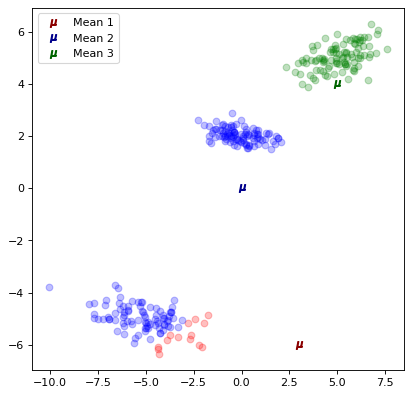

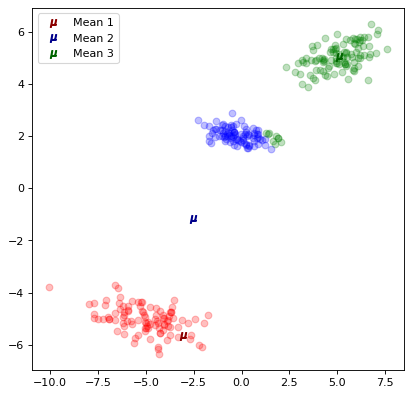

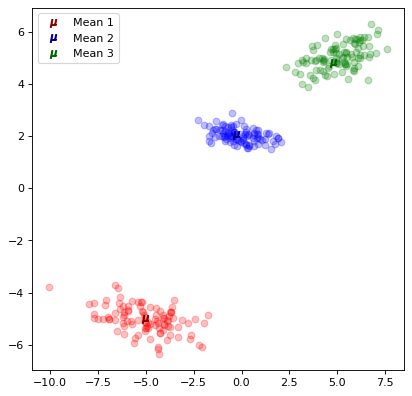

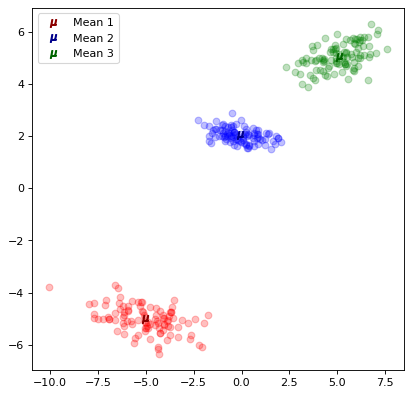

In [13]:
for step in range(0,4):
    
    figure(figsize=(6, 6), dpi=80)
    
    # Plot Datum:
    for i in range(len(X[0])):
        plt.scatter(X[0][i][0],X[0][i][1],color=colors[np.where(r_path[step][i] == 1)[0][0]+1],alpha=0.25)
        
     # Plot Means:
    plt.scatter(μ_path[step][0][0],μ_path[step][0][1],color='darkred',label="Mean 1",marker="$\mu$",s=50)
    plt.scatter(μ_path[step][1][0],μ_path[step][1][1],color='darkblue',label="Mean 2",marker="$\mu$",s=50)
    plt.scatter(μ_path[step][2][0],μ_path[step][2][1],color='darkgreen',label="Mean 3",marker="$\mu$",s=50)

    plt.legend()
    plt.show()

# DB Scan

DB scan works by chosing an effective radius $\epsilon$ as well as a minimum number of neighbors $minNeigh$ for a particular point to be considered a "core" point. Then you iterate over each data point within the datset and then check the number of points are within that $\epsilon$ radius. If the number of points is >= $minNeigh$ then it os a "core" point. If the number of points is < $minNeigh$ then it is an "outer" point. If an outer point is within the $\epsilon$ radius of a core point then it is further classified as a "border" point. If the outer point is not within that $\epsilon$ radius of a core then it is a "noise" or "outlier" point. These classifications can be seen in the below image:

![DBSCAN](img/DBSCAN.png)

These classes implicitly define a set of classifications. If two core points are within each others epsilon radius then they are the same class. All the border points belong to the class of the core point they belong to. Then the noise points are left as noise. This one is a lot simpler than the Gaussian one haha!(When I wrote that last sentence I did not yet code it. I was so wrong lol)

In [14]:
def getNeighborList(point,radius,dist,data):
    neighList = []
    for neighPoint in data:
        if (dist(point,neighPoint[1]) < radius):
            neighList.append(neighPoint[0])     
    return neighList

def DBSCAN(X,ϵ,minNeigh,dist):
    
    data = [] 
    
    index = 0
    for point in X[0]:
        data.append((index,point))
        index += 1
    
    # 0 <=> noise k ϵ {1,2,3..} <=> cluster k
    classification = dict()
    
    k = 0
    # Iterate over each point in the data
    for i in range(len(data)):
        # Check if it has been classified
        if not(i in classification):
            
            #If not, get its neighborlist
            N = getNeighborList(data[i][1],ϵ,dist,data)
            
            # If the number of neighbors is less than the minimum classify it as noise
            if len(N) < minNeigh:
                classification[i] = 0
            
            # If its a core point then expand its neighbors
            else:
                k += 1
                classification[i] = k
                S = N
                
                for pointIndex in S:
                    # If it has been previously classified as noise set it to belonging to group k
                    if pointIndex in classification:
                        if classification[pointIndex] == 0:
                            classification[pointIndex] = k
                            
                    # Check if it has not been classified
                    if not(pointIndex in classification):
                        classification[pointIndex] = k
                        
                        # Get pointIndex's neighbors
                        N = getNeighborList(data[pointIndex][1],ϵ,dist,data)
                        
                        # If pointIndex is a core point, add its neighbors to the processing list
                        if len(N) >= minNeigh:
                            S += N
           
    returnList = np.zeros(len(X[0]))
    for key, value in classification.items():
        returnList[key] = value
        
    return returnList

## DBSCAN TEST

In [15]:
X_1 = np.random.multivariate_normal(np.array([-3,-3]),datasets.make_spd_matrix(2),50)
X_2 = np.random.multivariate_normal(np.array([2,2]),datasets.make_spd_matrix(2)/2,150)
X_3 = np.random.multivariate_normal(np.array([0,0]),datasets.make_spd_matrix(2)/3,100)

X = np.array([np.concatenate((X_1,X_2,X_3))])

ϵ = [0.5,0.5,0.25]
MinPts = [10,20,10]

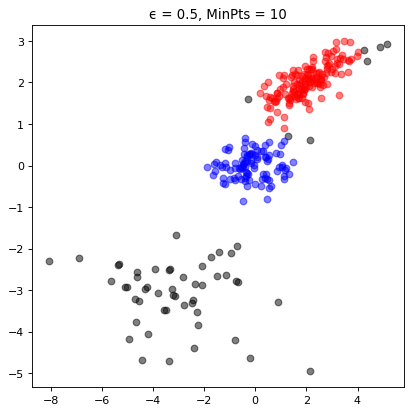

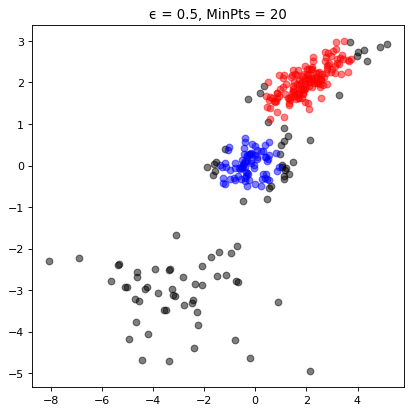

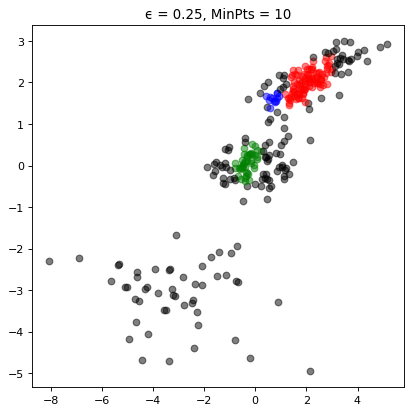

In [16]:
for j in range(3):
    
    figure(figsize=(6, 6), dpi=80)
    classification = DBSCAN(X,ϵ[j],MinPts[j],euclidDist)
    
    # Plot Datum:
    for i in range(len(X[0])):
        plt.scatter(X[0][i][0],X[0][i][1],color=colors[int(classification[i])],alpha=0.5)
    
    plt.title("ϵ = " + str(ϵ[j]) + ", MinPts = " + str(MinPts[j]))
    plt.show()

# Hierarchical Agglomorative Clustering

This algorithm works by iteratively combinining groups. Initially the algorithm assigns every datum to its own group. Then it iterativly combines the closest two groups. A pictoral representation of the algorithm can be seen below. Note, not all steps are shown. 

![HAC](img/HAC_Diagram.png)

The definition of closests heavily influences the algorithm. A few options are shown below.

![HACDISt](img/HAC_Dist.png)

In [17]:
# returns which two groups to merge
def Dmin(classifications,k,RDD):
    
    # Set the default min dist and indices for comparison
    minI = 0
    minJ = 1
    minDist = 100000000000000
    
    # Loop over each group. 
    for i in range(k):  
        for j in range(k):
            # Ensure we are not in the same group
            if not(j == i):
                
                # Set sub min
                minDistInGroup = 100000000000000
            
                # Find the minimum distance between elements in each group
                for index1 in classifications[i]:
                    for index2 in classifications[j]:
                        if(RDD[index1][index2] < minDistInGroup):
                            minDistInGroup = RDD[index1][index2]
            
                if minDistInGroup < minDist:
                    minI = i
                    minJ = j
                    minDist = minDistInGroup
                    
    return minI,minJ
                    
def HAC(X,K,D,returnPath = False):
    
    RDD = distance.cdist(X[0], X[0], 'euclidean')
    RDD = RDD + np.identity(len(X[0]))*(max(RDD.flatten())+1)
    
    # k = # of groups
    k = len(X[0])
    
    #Init all groups to be on their own
    classifications = [[i] for i in range(k)]
    
    classificationsPath = [copy.deepcopy(classifications)]
    
    while k > K:
        
        # Find the two groups to merge
        I,J = D(classifications,k,RDD)
        
        lower = min(I,J)
        upper = max(I,J)
        
        classifications[lower].extend(classifications[upper])
            
        classifications.pop(upper)
        
        classificationsPath.append(copy.deepcopy(classifications))
    
        k -= 1 
    classificationsReturn = np.zeros(len(X[0]))
    
    for classIndex in range(K):
        for pointIndex in classifications[classIndex]:
            classificationsReturn[pointIndex] = classIndex
    
    if returnPath:
        return classificationsReturn, classificationsPath
    
    return classificationsReturn

In [18]:
X_1 = np.random.multivariate_normal(np.array([-3,-3]),datasets.make_spd_matrix(2),10)
X_2 = np.random.multivariate_normal(np.array([2,2]),datasets.make_spd_matrix(2)/2,10)
X_3 = np.random.multivariate_normal(np.array([0,0]),datasets.make_spd_matrix(2)/3,10)

X = np.array([np.concatenate((X_1,X_2,X_3))])

In [19]:
classification,classificationsPath = HAC(X,2,Dmin,True)

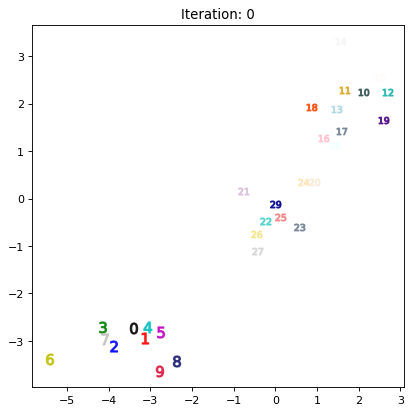

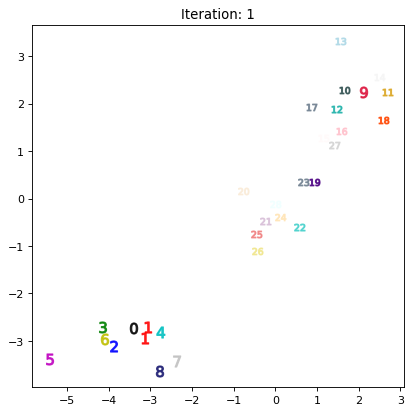

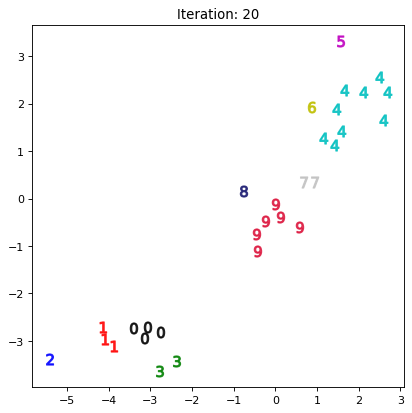

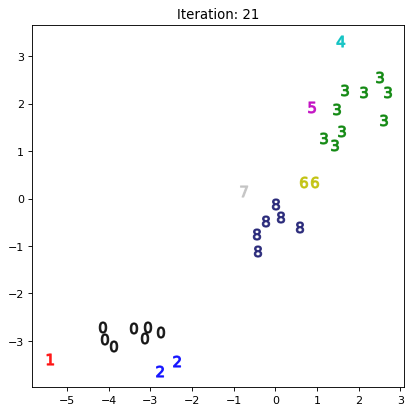

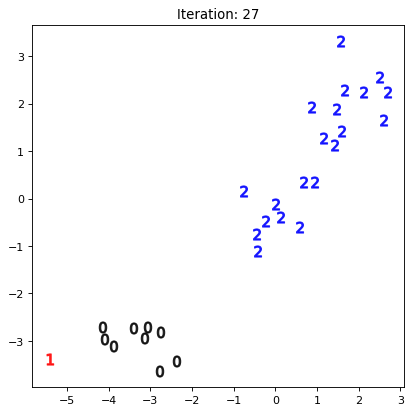

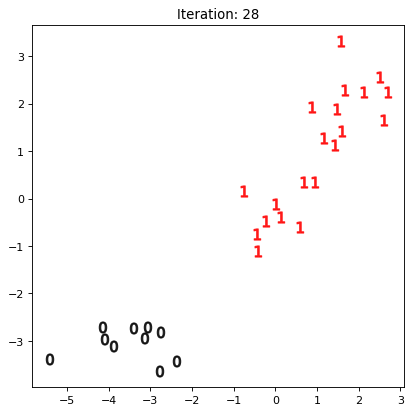

In [20]:
stepList = [0,1,20,21,27,28]
for step in stepList:
    figure(figsize=(6, 6), dpi=80)
    
    classificationsSub = classificationsPath[step]
    K = len(classificationsSub)
    for classIndex in range(K):
        for pointIndex in classificationsSub[classIndex]:
            classification[pointIndex] = classIndex

    # Plot Datum:
    for i in range(len(X[0])):
        plt.scatter(X[0][i][0],X[0][i][1],color=colors[int(classification[i])],alpha=0.8,marker="$"+str(int(classification[i]))+"$",s=100)
    
    plt.title("Iteration: " + str(step))
    
    plt.show()

# Overall Tests

## Ol Faithful Dataset

In [21]:
data = np.zeros((272,2))
for i in range(272):
    file = open("data/faithful.txt")
    dataTxt = file.read()[19*i:(i+1)*19].split()
    data[i] = [float(dataTxt[0]),float(dataTxt[1])]

minX = min(data.T[0])
maxX = max(data.T[0])

minY = min(data.T[1])
maxY = max(data.T[1])

widthX = maxX - minX
widthY = maxY - minY

X_ = np.array(2*(data.T[0] - minX)/widthX -1)
Y_ = np.array(2*(data.T[1] - minY)/widthY - 1)

N_count = 272

X = np.dstack((X_,Y_))
X = np.array([X[0][:N_count]])

XOF = X

In [22]:
classificationDBOF = DBSCAN(X,0.3,10,euclidDist)

μ_init = np.array([[1,1] for i in range(2)])
μ_init[0][0] = -1
μ_init[1][1] = -1
Σ_init= np.array([np.identity(2)*0.1 for i in range(2)])
π_init = np.array([0.5,0.5])
classificationGMMOF = GMM(X, μ_init, Σ_init, π_init)

classificationKMEANSOF = KMEANS(X,μ_init)

classificationHACOF = HAC(X,2,Dmin)

## Moons

In [23]:
X = datasets.make_moons(n_samples=250, noise=.05)
X = np.array([X[0]])

XMOON = X

classificationDBMOON = DBSCAN(X,0.3,10,euclidDist)

μ_init = np.array([[1,1] for i in range(2)])
μ_init[0][0] = -1
μ_init[1][1] = -1
Σ_init= np.array([np.identity(2)*0.1 for i in range(2)])
π_init = np.array([0.5,0.5])
classificationGMMMOON = GMM(X, μ_init, Σ_init, π_init)

classificationKMEANSMOON = KMEANS(X,μ_init)

classificationHACMOON = HAC(X,2,Dmin)

## Mixture of Gaussians

In [24]:
X_1 = np.random.multivariate_normal(np.random.uniform(-2,-1,2),datasets.make_spd_matrix(2),50)
X_2 = np.random.multivariate_normal(np.random.uniform(2,2.5,2),datasets.make_spd_matrix(2)/2,150)
X_3 = np.random.multivariate_normal(np.random.uniform(0,0,2),datasets.make_spd_matrix(2)/3,100)

X = np.array([np.concatenate((X_1,X_2,X_3))])

XGAUSS = X

classificationDBGAUSS = DBSCAN(X,0.5,10,euclidDist)

μ_init = np.array([[1,1] for i in range(3)])
μ_init[0][0] = -1
μ_init[1][1] = -1
Σ_init= np.array([np.identity(2)*0.1 for i in range(3)])
π_init = np.array([0.5,0.25,0.25])
classificationGMMGAUSS = GMM(X, μ_init, Σ_init, π_init)

classificationKMEANSGAUSS= KMEANS(X,μ_init)

classificationHACGAUSS = HAC(X,3,Dmin)

## S Curve

In [25]:
S1 = datasets.make_s_curve(n_samples=125, noise=.05)
S2 = datasets.make_s_curve(n_samples=125, noise=.05)
S = np.concatenate((S1[0],S2[0]-1.75))
X = np.zeros((1,250,2))
X[0,:,0] = S[:,0]
X[0,:,1] = S[:,2]

XS = X

classificationDBS = DBSCAN(X,0.5,10,euclidDist)

μ_init = np.array([[1,1] for i in range(2)])
μ_init[0][0] = -1
μ_init[1][1] = -1
Σ_init= np.array([np.identity(2)*0.1 for i in range(2)])
π_init = np.array([0.5,0.5])
classificationGMMS = GMM(X, μ_init, Σ_init, π_init)

classificationKMEANSS = KMEANS(X,μ_init)
classificationHACS = HAC(X,2,Dmin)

## Circles

In [26]:
X = datasets.make_circles(n_samples=250, noise=.05,factor=0.5)
X = np.array([X[0]])

XCIRCLE = X

classificationDBCIRCLE= DBSCAN(X,0.2,5,euclidDist)

μ_init = np.array([[1,1] for i in range(2)])
μ_init[0][0] = -1
μ_init[1][1] = -1
Σ_init= np.array([np.identity(2)*0.1 for i in range(2)])
π_init = np.array([0.5,0.5])
classificationGMMCIRCLE = GMM(X, μ_init, Σ_init, π_init)

classificationKMEANSCIRCLE = KMEANS(X,μ_init)
classificationHACCIRCLE = HAC(X,2,Dmin)

# Plots

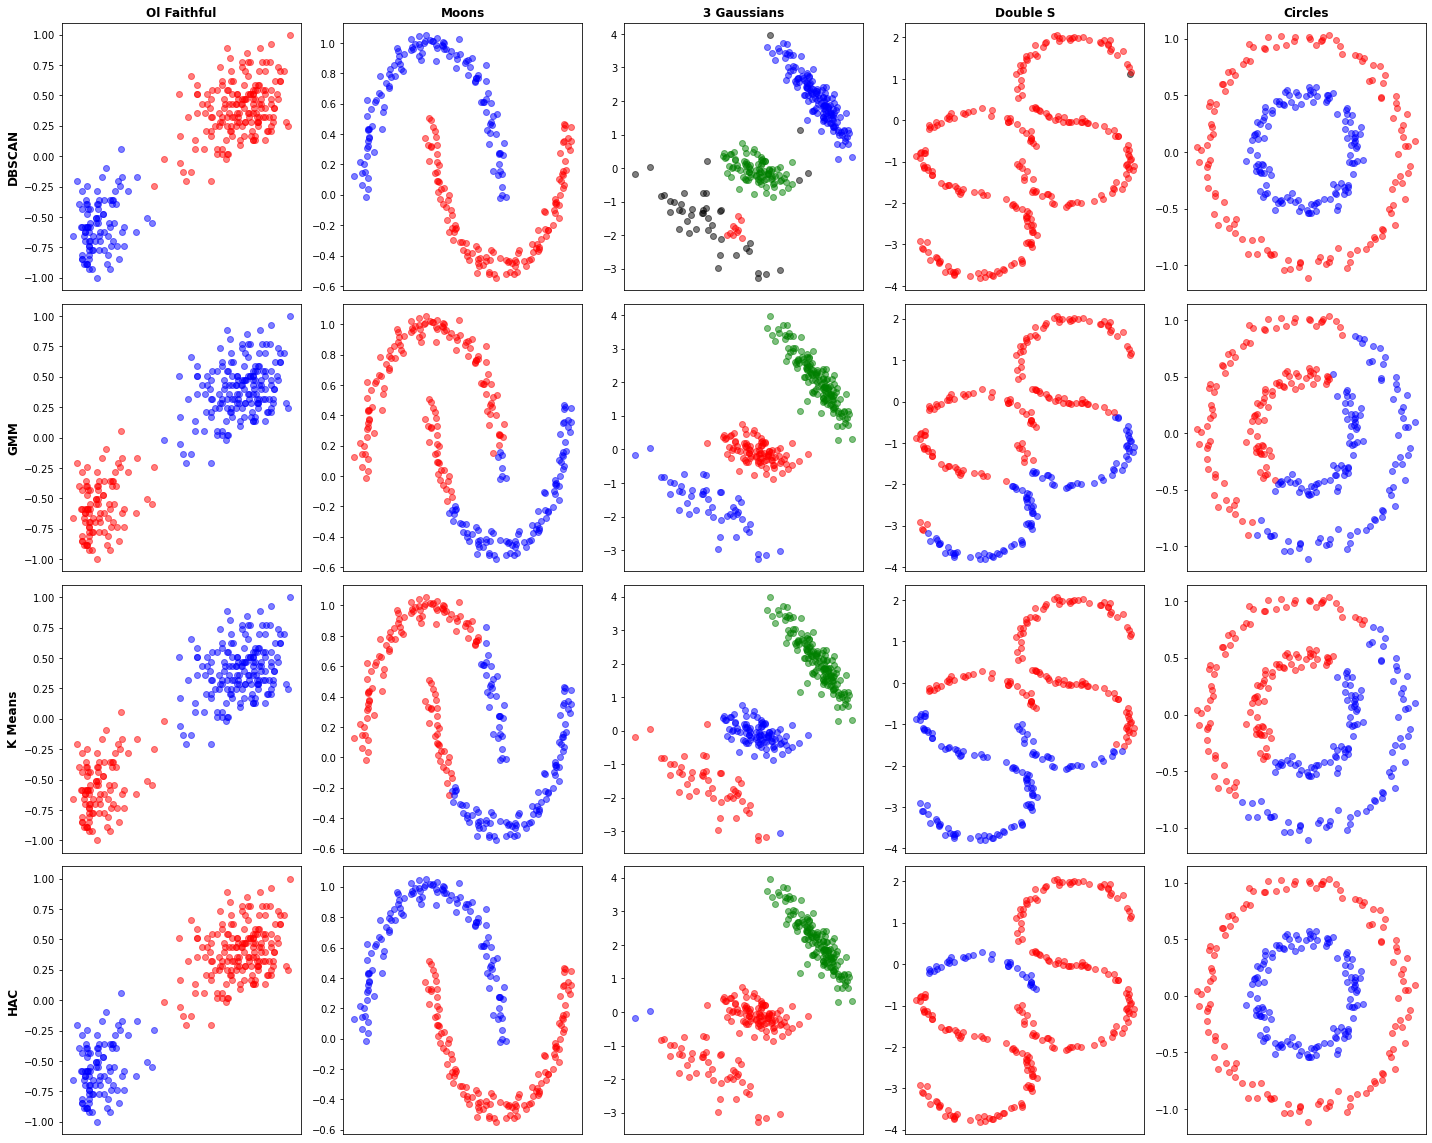

In [27]:
fig, ax  = plt.subplots(4,5,figsize=(20,16))

# OL FAITHFUL
for i in range(len(XOF[0])):
    ax[0][0].scatter(XOF[0][i][0],XOF[0][i][1],color=colors[int(classificationDBOF[i])],alpha=0.5)
    ax[1][0].scatter(XOF[0][i][0],XOF[0][i][1],color=colors[int(classificationGMMOF[i])+1],alpha=0.5)
    ax[2][0].scatter(XOF[0][i][0],XOF[0][i][1],color=colors[int(classificationKMEANSOF[i])+1],alpha=0.5)
    ax[3][0].scatter(XOF[0][i][0],XOF[0][i][1],color=colors[int(classificationHACOF[i])+1],alpha=0.5)
    

# MOONS
for i in range(len(XMOON[0])):
    ax[0][1].scatter(XMOON[0][i][0],XMOON[0][i][1],color=colors[int(classificationDBMOON[i])],alpha=0.5)
    ax[1][1].scatter(XMOON[0][i][0],XMOON[0][i][1],color=colors[int(classificationGMMMOON[i])+1],alpha=0.5)
    ax[2][1].scatter(XMOON[0][i][0],XMOON[0][i][1],color=colors[int(classificationKMEANSMOON[i])+1],alpha=0.5)
    ax[3][1].scatter(XMOON[0][i][0],XMOON[0][i][1],color=colors[int(classificationHACMOON[i])+1],alpha=0.5)
    

# GAUSS
for i in range(len(XGAUSS[0])):
    ax[0][2].scatter(XGAUSS[0][i][0],XGAUSS[0][i][1],color=colors[int(classificationDBGAUSS[i])],alpha=0.5)
    ax[1][2].scatter(XGAUSS[0][i][0],XGAUSS[0][i][1],color=colors[int(classificationGMMGAUSS[i])+1],alpha=0.5)
    ax[2][2].scatter(XGAUSS[0][i][0],XGAUSS[0][i][1],color=colors[int(classificationKMEANSGAUSS[i])+1],alpha=0.5)
    ax[3][2].scatter(XGAUSS[0][i][0],XGAUSS[0][i][1],color=colors[int(classificationHACGAUSS[i])+1],alpha=0.5)
    
# S
for i in range(len(XS[0])):
    ax[0][3].scatter(XS[0][i][0],XS[0][i][1],color=colors[int(classificationDBS[i])],alpha=0.5)
    ax[1][3].scatter(XS[0][i][0],XS[0][i][1],color=colors[int(classificationGMMS[i])+1],alpha=0.5)
    ax[2][3].scatter(XS[0][i][0],XS[0][i][1],color=colors[int(classificationKMEANSS[i])+1],alpha=0.5)
    ax[3][3].scatter(XS[0][i][0],XS[0][i][1],color=colors[int(classificationHACS[i])+1],alpha=0.5)

# CIRCLE
for i in range(len(XCIRCLE[0])):
    ax[0][4].scatter(XCIRCLE[0][i][0],XCIRCLE[0][i][1],color=colors[int(classificationDBCIRCLE[i])],alpha=0.5)
    ax[1][4].scatter(XCIRCLE[0][i][0],XCIRCLE[0][i][1],color=colors[int(classificationGMMCIRCLE[i])+1],alpha=0.5)
    ax[2][4].scatter(XCIRCLE[0][i][0],XCIRCLE[0][i][1],color=colors[int(classificationKMEANSCIRCLE[i])+1],alpha=0.5)
    ax[3][4].scatter(XCIRCLE[0][i][0],XCIRCLE[0][i][1],color=colors[int(classificationHACCIRCLE[i])+1],alpha=0.5)

    
# TITLES:
cols = ['Ol Faithful','Moons','3 Gaussians','Double S', 'Circles']
rows = ['DBSCAN','GMM','K Means','HAC']

for a, col in zip(ax[0], cols):
    a.set_title(col,fontweight="bold")

for a, row in zip(ax[:,0], rows):
    a.set_ylabel(row, rotation=90, size='large',fontweight="bold")


# Disable Ticks
for i in range(4):
    for j in range(5):
        ax[i][j].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
        
        ax[i][j].tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off


fig.tight_layout()        
plt.savefig("Clustering Algorithm Comparison")